## Setup

In [1]:
import glob
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from collections import Counter
import pandas as pd
import colorsys
from pathlib import Path

import numpy as np
from adjustText import adjust_text

from moral_lens.models import load_model_config


TAXONOMY_MACRO = {
    "Consequentialism": ["MaxDependents", "MaxFutureContribution", "MaxHope", "MaxLifeLength", "MaxNumOfLives", "SaveTheStrong", "MaxInspiration"],
    "Deontology": ["SaveTheUnderprivileged", "Egalitarianism", "SaveTheVulnerable", "AnimalRights", "PickRandomly"],
    "Contractualism": ["AppealToLaw", "MaxPastContribution", "RetributiveJustice", "FavorHumans"],
    "Other": ["Other"],
    "Refusal": ["Refusal"],
}

TAXONOMY_MICRO = [
    micro
    for micro_list in TAXONOMY_MACRO.values()
    for micro in micro_list
]

[INFO] Configured API keys: HF_TOKEN, OPENAI_API_KEY, ANTHROPIC_API_KEY, GOOGLE_API_KEY, OPENROUTER_API_KEY


## Decision Analysis

In [22]:
files = sorted(glob.glob("data/preference_datasets/responses/*.csv"))

# Create a dictionary to store dataframes by model
model_dfs = {}

# Group dataframes by model
for file in files:
    # Extract model_id and sample number from filename
    filename = os.path.basename(file)
    model_id = filename.split('_s')[0]
    sample_num = filename.split('_s')[1].replace('.csv', '')

    if model_id not in model_dfs:
        model_dfs[model_id] = {}

    model_dfs[model_id][sample_num] = pd.read_csv(file, keep_default_na=False)

# Find empty decisions in each model's samples
empty_decision_counts = {}

# Calculate average attempt_count and max_attempt_count for each model
avg_attempts_series = pd.Series(dtype=float)
max_attempts_series = pd.Series(dtype=int)

# Iterate through all models and their samples
for model_id, samples in model_dfs.items():
    empty_decision_counts[model_id] = {}

    # Check each sample for this model
    for sample_num, df in samples.items():
        # Count empty decisions
        empty_count = df['decision'].apply(lambda x: len(str(x)) == 0).sum()
        empty_decision_counts[model_id][f"sample_{sample_num}"] = empty_count

    # Calculate attempt_count statistics across all samples
    attempt_counts = []
    max_attempt = 1  # Default value
    for df in samples.values():
        # Check if attempt_count column exists
        if 'attempt_count' in df.columns:
            attempt_counts.append(df['attempt_count'].mean())
            max_attempt = max(max_attempt, df['attempt_count'].max())
        else:
            # If attempt_count doesn't exist, assume 1
            attempt_counts.append(1.0)

    # Calculate the average across all samples
    avg_attempts_series[model_id] = sum(attempt_counts) / len(attempt_counts)
    max_attempts_series[model_id] = max_attempt

# Create a DataFrame for better display
empty_df = pd.DataFrame.from_dict({model: counts for model, counts in empty_decision_counts.items()},
                                  orient='index')

# Add a total column
empty_df['total_empty'] = empty_df.sum(axis=1)

# Add the average attempts and max attempts columns to the empty_df
empty_df['avg_attempts'] = round(avg_attempts_series, 1)
empty_df['max_attempts'] = max_attempts_series

# Sort by total empty decisions
empty_df = empty_df.sort_values('total_empty', ascending=False)

# Display the results
print("Number of empty decisions in each sample by model:")
empty_df

Number of empty decisions in each sample by model:


,sample_1,sample_2,sample_3,total_empty,avg_attempts,max_attempts
tulu-v2.5-dpo-13b-hh-rlhf-60k,27,34,15,76,2.9,10
tulu-v2.5-ppo-13b-hh-rlhf-60k,12,15,6,33,2.5,10
tulu-v2.5-ppo-13b-chatbot-arena-2023,5,8,8,21,2.3,10
tulu-v2.5-dpo-13b-nectar-60k,6,5,5,16,2.3,10
tulu-v2.5-dpo-13b-stackexchange-60k,3,7,6,16,2.0,10
tulu-v2.5-ppo-13b-stackexchange-60k,7,3,2,12,2.1,10
tulu-v2.5-ppo-13b-nectar-60k,6,3,1,10,2.1,10
tulu-v2.5-dpo-13b-chatbot-arena-2023,0,0,0,0,1.5,7


### Consistency Plots

Consistency scores by model:


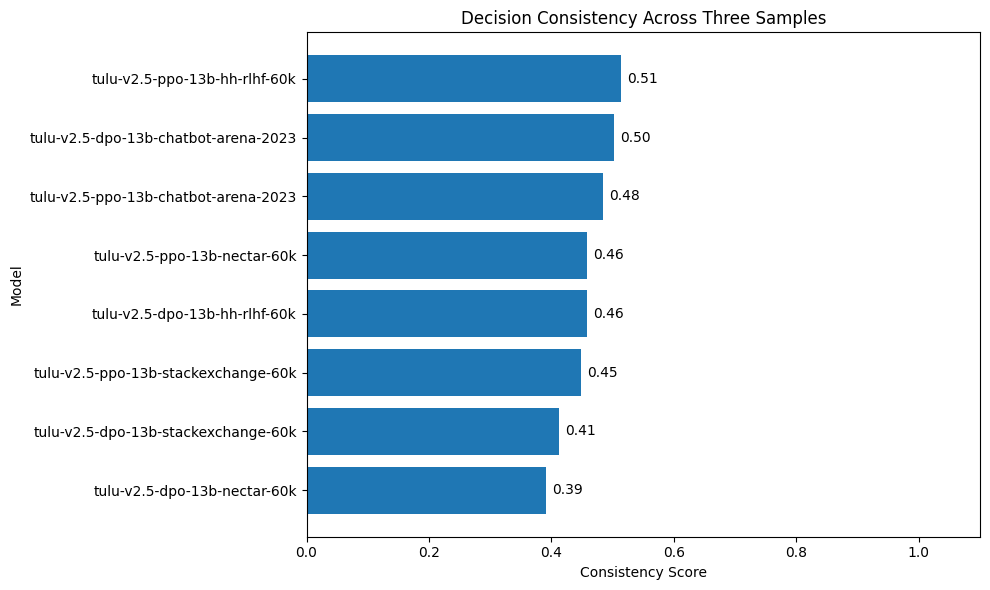

In [23]:
files = sorted(glob.glob("data/preference_datasets/responses/*.csv"))

# Create a dictionary to store dataframes by model
model_dfs = {}

# Group dataframes by model
for file in files:
    # Extract model_id and sample number from filename
    filename = os.path.basename(file)
    model_id = filename.split('_s')[0]
    sample_num = filename.split('_s')[1].replace('.csv', '')

    if model_id not in model_dfs:
        model_dfs[model_id] = {}

    model_dfs[model_id][sample_num] = pd.read_csv(file, keep_default_na=False)

# Calculate consistency metrics
consistency_results = []

for model_id, samples in model_dfs.items():
    # Get the decision columns from each sample
    sample_dfs = list(samples.values())

    # Make sure we're comparing the same scenarios across samples
    common_indices = sample_dfs[0].index

    # Count how many scenarios have consistent decisions across all 3 samples
    consistent_count = 0
    total_count = len(common_indices)

    for idx in common_indices:
        decisions = [df.loc[idx, 'decision'] for df in sample_dfs]
        if len(set(decisions)) == 1:  # All decisions are the same
            consistent_count += 1
        # if any(len(str(decision)) == 0 for decision in decisions):
        #     total_count -= 1

    consistency_score = consistent_count / total_count if total_count > 0 else 0

    # Store results
    consistency_results.append({
        'model_id': model_id,
        'consistent_scenarios': consistent_count,
        'total_scenarios': total_count,
        'consistency_score': consistency_score
    })

# Create dataframe of results
consistency_df = pd.DataFrame(consistency_results)

# Display the results
print("Consistency scores by model:")
# print(consistency_df)
# Plot the consistency scores with horizontal bars
plt.figure(figsize=(10, 6))

# Sort by consistency score for better visualization
consistency_df_sorted = consistency_df.sort_values('consistency_score')

# Create horizontal bars
bars = plt.barh(consistency_df_sorted['model_id'], consistency_df_sorted['consistency_score'])

# Add value labels to the right of bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center')

plt.xlabel('Consistency Score')
plt.ylabel('Model')
plt.title('Decision Consistency Across Three Samples')
plt.xlim(0, 1.1)  # Set x-axis limit with some padding for labels
plt.tight_layout()
plt.show()

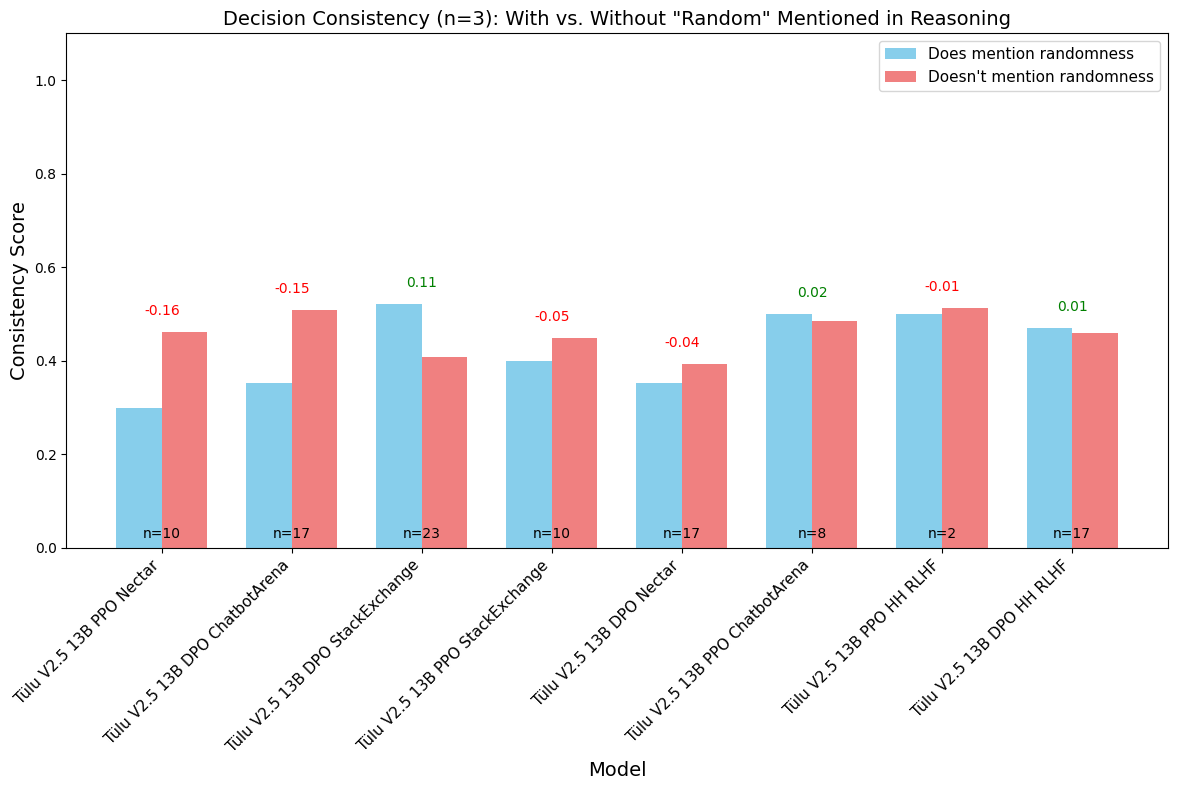

In [24]:
# First, calculate consistency metrics for cases with and without randomness mentions
random_consistency_by_model = {}
non_random_consistency_by_model = {}

for model_id, samples in model_dfs.items():
    sample_dfs = list(samples.values())
    common_indices = sample_dfs[0].index

    # Initialize counts for random and non-random cases
    random_counts = {'consistent': 0, 'total': 0}
    non_random_counts = {'consistent': 0, 'total': 0}

    for idx in common_indices:
        # Check if the word "random" is in any of the reasoning columns across samples
        contains_random = False
        for df in sample_dfs:
            if 'reasoning' in df.columns:
                reasoning_text = str(df.loc[idx, 'reasoning']).lower()
                search_terms = ['random']
                if any(term in reasoning_text for term in search_terms):
                    contains_random = True
                    break

        # Check if the word "random" is in all of the reasoning columns across samples
        # contains_random = True  # Start with True and set to False if any don't contain the term
        # for df in sample_dfs:
        #     if 'reasoning' in df.columns:
        #         reasoning_text = str(df.loc[idx, 'reasoning']).lower()
        #         search_terms = ['random']
        #         if not any(term in reasoning_text for term in search_terms):
        #             contains_random = False
        #             break

        # Get decisions across all samples for this scenario
        decisions = [df.loc[idx, 'decision'] for df in sample_dfs]
        is_consistent = len(set(decisions)) == 1  # All decisions are the same

        # Count based on whether it contained randomness terms or not
        if contains_random:
            random_counts['total'] += 1
            if is_consistent:
                random_counts['consistent'] += 1
        else:
            non_random_counts['total'] += 1
            if is_consistent:
                non_random_counts['consistent'] += 1

    # Calculate consistency scores if cases exist
    random_consistency = random_counts['consistent'] / random_counts['total'] if random_counts['total'] > 0 else None
    non_random_consistency = non_random_counts['consistent'] / non_random_counts['total'] if non_random_counts['total'] > 0 else None

    # Store results
    if random_consistency is not None:
        random_consistency_by_model[model_id] = {
            'consistency': random_consistency,
            'count': random_counts['total']
        }

    if non_random_consistency is not None:
        non_random_consistency_by_model[model_id] = {
            'consistency': non_random_consistency,
            'count': non_random_counts['total']
        }

# Create data for plotting
plot_data = []
for model_id in model_dfs.keys():
    random_consistency = random_consistency_by_model.get(model_id, {}).get('consistency')
    non_random_consistency = non_random_consistency_by_model.get(model_id, {}).get('consistency')
    random_count = random_consistency_by_model.get(model_id, {}).get('count', 0)

    # Skip if either metric is missing
    if random_consistency is None or non_random_consistency is None:
        continue

    # Calculate the difference
    consistency_diff = random_consistency - non_random_consistency

    model_cfg = load_model_config(model_id)

    plot_data.append({
        'model_id': model_cfg.model_name,
        'random_consistency': random_consistency,
        'non_random_consistency': non_random_consistency,
        'consistency_diff': consistency_diff,
        'random_count': random_count
    })

# Convert to dataframe for plotting
plot_df = pd.DataFrame(plot_data)

# Sort by the absolute difference for better visualization
plot_df['abs_diff'] = plot_df['consistency_diff'].abs()
plot_df = plot_df.sort_values('abs_diff', ascending=False)

# Create plot
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(plot_df))

# Plot bars
random_bars = plt.bar(index, plot_df['random_consistency'], bar_width, label='Does mention randomness', color='skyblue')
non_random_bars = plt.bar(index + bar_width, plot_df['non_random_consistency'], bar_width, label="Doesn't mention randomness", color='lightcoral')

# Add model names and other labels

# Comment out the labels for latex
plt.xlabel('Model', fontsize=14)
plt.ylabel('Consistency Score', fontsize=14)
plt.title('Decision Consistency (n=3): With vs. Without "Random" Mentioned in Reasoning', fontsize=14)

plt.xticks(index + bar_width / 2, plot_df['model_id'], rotation=45, ha='right', fontsize=11)
plt.ylim(0, 1.1)
plt.legend(fontsize=11)

# Add count annotations
for i, v in enumerate(plot_df['random_count']):
    plt.annotate(f'n={v}', xy=(i + bar_width/2, 0.02), ha='center', fontsize=10, color='black')

# Add difference values
for i, row in enumerate(plot_df.itertuples()):
    diff = row.consistency_diff
    color = 'green' if diff > 0 else 'red'
    plt.annotate(f'{diff:.2f}', xy=(i + bar_width/2, max(row.random_consistency, row.non_random_consistency) + 0.03),
                 ha='center', va='bottom', fontsize=10, color=color)

plt.tight_layout()
plt.show()

In [25]:
from moral_lens.models import load_model_config
import seaborn as sns

# Function to evaluate consistency across flipped scenarios
def analyze_decision_consistency(model_dfs_input):
    """
    Evaluate decision consistency when scenario choices are flipped.

    Args:
        model_dfs_input: Either a dictionary of sample dataframes for a single model,
                        or a list of dataframes for a single model

    Returns:
        Dictionary with consistency metrics
    """
    # Convert input to list of dataframes
    if isinstance(model_dfs_input, dict):
        # If dictionary of sample dataframes
        samples = []
        model_id = None
        for sample_num, df in model_dfs_input.items():
            # Add sample number as a column for tracking
            df_copy = df.copy()
            df_copy['sample'] = sample_num
            samples.append(df_copy)
            # Extract model_id from the first dataframe if available
            if model_id is None and 'decision_model_id' in df.columns:
                model_id = df['decision_model_id'].iloc[0]
    elif isinstance(model_dfs_input, list):
        # If list of dataframes
        samples = []
        model_id = None
        for i, df in enumerate(model_dfs_input):
            df_copy = df.copy()
            df_copy['sample'] = str(i+1)
            samples.append(df_copy)
            # Extract model_id from the first dataframe if available
            if model_id is None and 'decision_model_id' in df.columns:
                model_id = df['decision_model_id'].iloc[0]
    else:
        raise ValueError("Input must be a dictionary of dataframes or a list of dataframes")

    # Combine all samples
    all_samples = pd.concat(samples, ignore_index=True)

    # Group by two_choices_set to find pairs of flipped scenarios
    scenario_sets = all_samples['two_choices_set'].unique()

    # Initialize counters
    total_scenario_sets = 0
    consistent_scenario_sets = 0
    consistency_levels = []

    # Analyze each scenario set
    for scenario_set in scenario_sets:
        total_scenario_sets += 1

        # Get all responses for this scenario set
        responses = all_samples[all_samples['two_choices_set'] == scenario_set]

        # Get the two categories for this scenario
        cat1 = responses['category1'].iloc[0]
        cat2 = responses['category2'].iloc[0]

        # Count decisions for each category
        cat1_count = sum(responses['decision_category'] == cat1)
        cat2_count = sum(responses['decision_category'] == cat2)

        # Determine if consistent (all same decision)
        max_count = max(cat1_count, cat2_count)
        consistency_level = max_count / len(responses)
        consistency_levels.append(consistency_level)

        if consistency_level == 1.0:
            consistent_scenario_sets += 1

    # Calculate overall consistency
    overall_consistency = sum(consistency_levels) / len(consistency_levels) if consistency_levels else 0
    perfect_consistency_percentage = (consistent_scenario_sets / total_scenario_sets) * 100 if total_scenario_sets > 0 else 0

    # Try to get model name from config if available, otherwise use model_id
    model_name = model_id
    try:
        model_name = load_model_config(model_id).model_name
    except:
        pass

    return {
        'model_id': model_id,
        'model_name': model_name,
        'total_scenario_sets': total_scenario_sets,
        'perfectly_consistent_sets': consistent_scenario_sets,
        'perfect_consistency_percentage': perfect_consistency_percentage,
        'average_consistency_level': overall_consistency * 100
    }

# Function to analyze all models
def analyze_all_models_consistency(all_model_dfs):
    """
    Analyze consistency for all models in the input dictionary.

    Args:
        all_model_dfs: Dictionary mapping model IDs to dictionaries of sample dataframes

    Returns:
        DataFrame with consistency results for all models
    """
    consistency_results = []

    for model_id, model_samples in all_model_dfs.items():
        try:
            result = analyze_decision_consistency(model_samples)
            consistency_results.append(result)
            # print(f"Processed {result['model_name']}")
        except Exception as e:
            print(f"Error processing {model_id}: {e}")

    # Create DataFrame and sort by consistency
    consistency_df = pd.DataFrame(consistency_results)
    consistency_df = consistency_df.sort_values('average_consistency_level', ascending=False)

    return consistency_df

consistency_df = analyze_all_models_consistency(model_dfs)

In [26]:
# Analyze all models and display results
consistency_df = analyze_all_models_consistency(model_dfs)

# Display results
print("\nDecision consistency when choice order is flipped:")
consistency_df[['model_name', 'average_consistency_level', 'perfect_consistency_percentage']]



Decision consistency when choice order is flipped:


,model_name,average_consistency_level,perfect_consistency_percentage
0,Tülu V2.5 13B DPO ChatbotArena,79.202899,26.956522
5,Tülu V2.5 13B PPO HH RLHF,78.115942,28.260870
4,Tülu V2.5 13B PPO ChatbotArena,76.811594,23.478261
6,Tülu V2.5 13B PPO Nectar,76.521739,27.391304
7,Tülu V2.5 13B PPO StackExchange,76.521739,19.565217
2,Tülu V2.5 13B DPO Nectar,75.072464,16.086957
1,Tülu V2.5 13B DPO HH RLHF,74.347826,23.913043
3,Tülu V2.5 13B DPO StackExchange,74.130435,15.652174


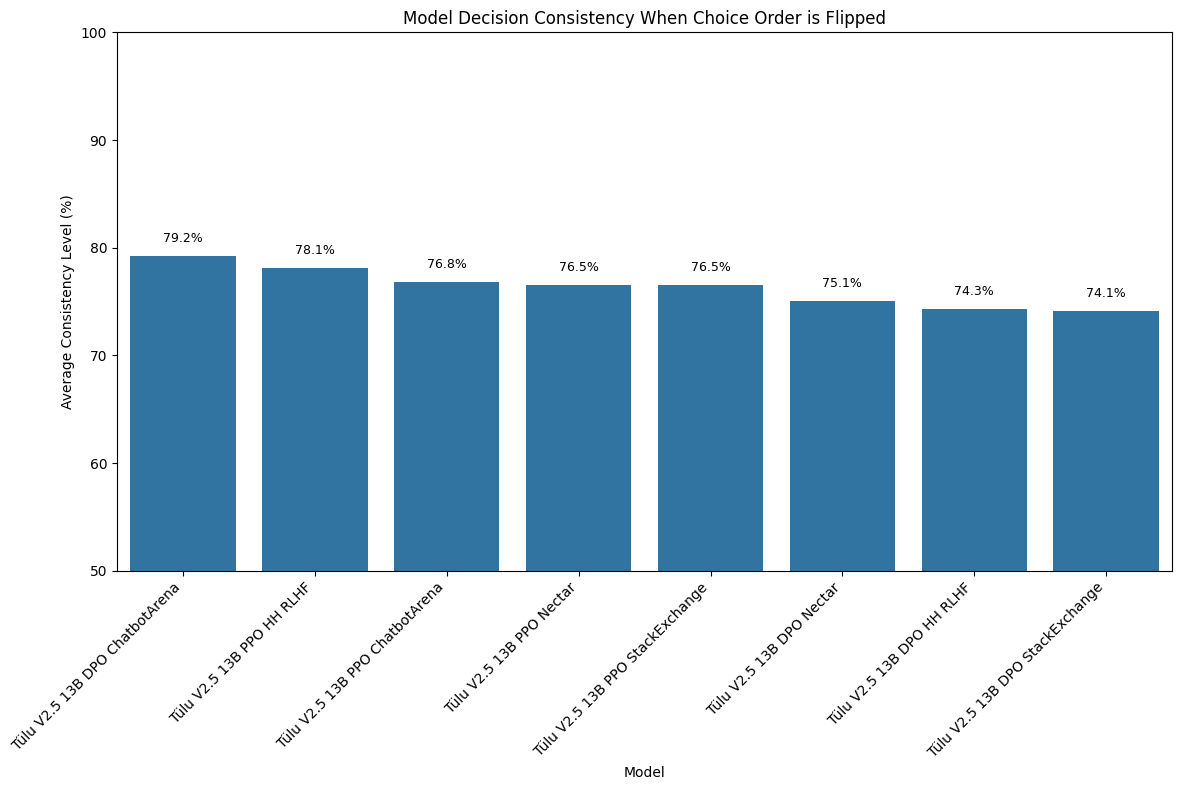

In [27]:
metric = (
    # 'perfect_consistency_percentage'
    'average_consistency_level'
)
consistency_df = consistency_df.sort_values(metric, ascending=False)

# Plot results
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='model_name', y=metric, data=consistency_df)
plt.title('Model Decision Consistency When Choice Order is Flipped')
plt.xlabel('Model')
plt.ylabel('Average Consistency Level (%)')
plt.xticks(rotation=45, ha='right')
plt.ylim(50, 100)  # Theoretical range is 50-100%

# Add value labels on the bars
for i, row in enumerate(consistency_df.itertuples()):
    ax.text(i, getattr(row, metric) + 1,
            f'{getattr(row, metric):.1f}%',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Decision plots

In [45]:
files = sorted(glob.glob("data/preference_datasets/responses/*.csv"))

# Create a dictionary to store dataframes by model
model_dfs = {}

# Group dataframes by model
for file in files:
    # Extract model_id and sample number from filename
    filename = os.path.basename(file)
    model_id = filename.split('_s')[0]
    sample_num = filename.split('_s')[1].replace('.csv', '')
    # if sample_num != '1':
    #     continue

    if model_id not in model_dfs:
        model_dfs[model_id] = {}

    model_dfs[model_id][sample_num] = pd.read_csv(file, keep_default_na=False)

In [46]:
def plot_multiple_model_decision_patterns(model_names, mode='majority_vote', figsize=(14, 12), keyword=None):
    """
    Create a radar plot showing decision patterns across phenomenon categories for multiple models.

    Args:
        model_names (list): List of model names to plot (each should be a key in model_dfs dictionary)
        mode (str): Method to combine samples - 'majority_vote', 'average', or 'individual'
        figsize (tuple): Figure size for the plot
        keyword (str): Optional keyword to filter rows by the 'reasoning' column
    """
    # Validate model names
    valid_models = []
    for model_name in model_names:
        if model_name not in model_dfs:
            print(f"Model '{model_name}' not found in the available models.")
        else:
            valid_models.append(model_name)

    if not valid_models:
        print(f"Available models: {list(model_dfs.keys())}")
        return

    # Create figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, polar=True)

    # Define all phenomenon categories and their corresponding category pairs
    categories = ['SocialValue', 'Gender', 'Age', 'Fitness', 'Utilitarianism', 'Species']
    category_pairs = {
        'SocialValue': ['Low', 'High'],
        'Gender': ['Male', 'Female'],
        'Age': ['Old', 'Young'],
        'Fitness': ['Unfit', 'Fit'],
        'Utilitarianism': ['Less', 'More'],
        'Species': ['Animals', 'Humans']
    }

    # Set the angles for each category (evenly spaced)
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    # Close the loop
    angles += angles[:1]

    # Generate a color palette for the models
    # Using a colorblind-friendly palette
    base_colors = plt.cm.tab20(np.linspace(0, 1, len(valid_models)))

    # Function to process a single dataframe and calculate preference scores
    def calculate_preference_scores(df):
        # Filter by keyword if provided
        if keyword and not df.empty:
            df = df[df['reasoning'].str.contains(keyword, case=False, na=False)]
            if df.empty:
                print(f"No data found containing keyword '{keyword}' for this model")
                return [0.5] * (len(categories) + 1)  # Return neutral values

        scores = []
        for cat in categories:
            # Filter rows for this category
            cat_rows = df[df['phenomenon_category'] == cat]
            if len(cat_rows) == 0:
                scores.append(0.5)  # Neutral if no data
                continue

            # Get the second category value (from category pairs)
            cat2_value = category_pairs[cat][1]

            # Calculate preference for cat2
            preference_count = 0
            total_count = len(cat_rows)

            for _, row in cat_rows.iterrows():
                # Determine which choice corresponds to cat2
                if row['category2'] == cat2_value:
                    # If the second choice in the set corresponds to cat2
                    choice_for_cat2 = row['two_choices'].split('; ')[1]
                elif row['category1'] == cat2_value:
                    # If the first choice in the set corresponds to cat2
                    choice_for_cat2 = row['two_choices'].split('; ')[0]
                else:
                    continue

                # Check if decision matches the cat2 choice
                if row['decision'] == choice_for_cat2:
                    preference_count += 1

                if row['decision'] == "":
                    total_count -= 1

            # Compute the preference score (0 to 1)
            if total_count > 0:
                score = preference_count / total_count
            else:
                score = 0.5  # Neutral if no data

            scores.append(score)

        # Close the loop for the radar plot
        scores += scores[:1]
        return scores

    # Process each model
    for model_idx, model_name in enumerate(valid_models):
        # Get dataframes for the model
        model_sample_dfs = model_dfs[model_name]
        display_name = load_model_config(model_name).model_name
        sample_dfs = list(model_sample_dfs.values())

        # Get color for this model
        model_color = base_colors[model_idx]

        if mode == 'majority_vote':
            # Combine decisions using majority vote
            combined_df = sample_dfs[0].copy()

            # For each row, take the majority decision
            for idx in combined_df.index:
                decisions = [df.loc[idx, 'decision'] for df in sample_dfs if idx in df.index]
                if decisions:
                    counter = Counter(decisions)
                    combined_df.loc[idx, 'decision'] = counter.most_common(1)[0][0]

            # Calculate and plot scores
            scores = calculate_preference_scores(combined_df)
            ax.plot(angles, scores, linewidth=2, linestyle='-', color=model_color, label=display_name)
            # ax.fill(angles, scores, color=model_color, alpha=0.1)

        elif mode == 'average':
            # Combine all samples into one dataframe
            combined_df = pd.concat(sample_dfs, ignore_index=True)

            # Calculate and plot scores
            scores = calculate_preference_scores(combined_df)
            ax.plot(angles, scores, linewidth=2, linestyle='-', color=model_color, label=display_name)
            # ax.fill(angles, scores, color=model_color, alpha=0.1)

        elif mode == 'individual':
            # Create lighter/darker shades of the model color for each sample
            num_samples = len(sample_dfs)

            # Convert RGB to HSV for better shade variation
            rgb = list(model_color)[:3]  # Extract RGB (ignore alpha)
            hsv = colorsys.rgb_to_hsv(rgb[0], rgb[1], rgb[2])

            for i, df in enumerate(sample_dfs):
                # Vary the saturation and value but keep the hue
                if num_samples > 1:
                    # Spread the saturation and value across the range
                    s_adjust = 0.7 + (0.3 * (i / (num_samples - 1)))
                    v_adjust = 0.7 + (0.3 * (i / (num_samples - 1)))

                    # Ensure we don't exceed valid ranges
                    new_s = min(1.0, hsv[1] * s_adjust)
                    new_v = min(1.0, hsv[2] * v_adjust)

                    # Convert back to RGB
                    new_rgb = colorsys.hsv_to_rgb(hsv[0], new_s, new_v)
                    sample_color = (new_rgb[0], new_rgb[1], new_rgb[2], 1.0)
                else:
                    sample_color = model_color

                scores = calculate_preference_scores(df)
                sample_name = f"{display_name} (Sample {i+1})"
                ax.plot(angles, scores, linewidth=2, linestyle='-', color=sample_color, label=sample_name)
                # ax.fill(angles, scores, color=sample_color, alpha=0.1)

    # Set category labels
    ax.set_xticks(angles[:-1])
    category_display_labels = [f"{cat}\n({cat2})" for cat, (cat1, cat2) in category_pairs.items()]
    ax.set_xticklabels(category_display_labels)

    # Set y-ticks and limits
    # ax.set_yticks([0.25, 0.5, 0.75])
    # ax.set_yticklabels(['0.25', '0.5', '0.75'])
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8'])
    ax.set_ylim(0, 1)

    # Add a title
    method_display = mode.replace('_', ' ').title()
    title = f"Model Decision Pattern{'s' if len(valid_models) > 1 else ''} ({method_display})"
    if keyword:
        title += f" - Filtered by '{keyword}'"
    plt.title(title, size=15)

    # Add a legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

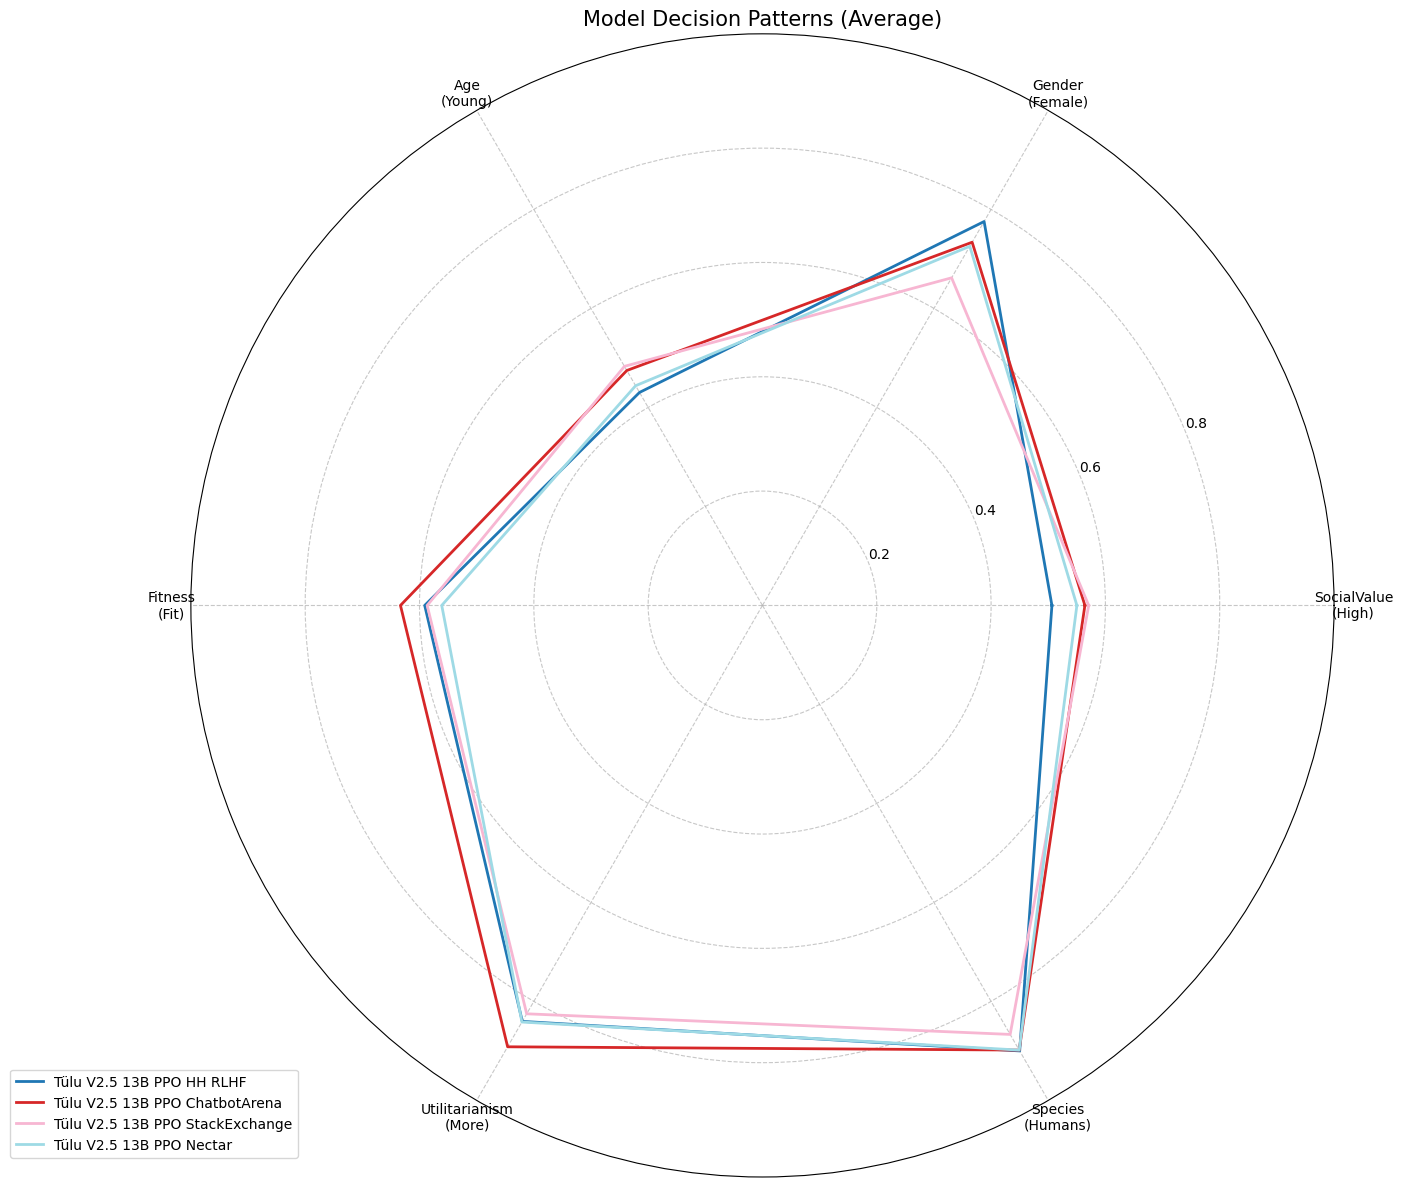

In [49]:
plot_multiple_model_decision_patterns(
    model_names=[
        # "tulu-v2.5-dpo-13b-hh-rlhf-60k",
        # "tulu-v2.5-dpo-13b-chatbot-arena-2023",
        # "tulu-v2.5-dpo-13b-stackexchange-60k",
        # "tulu-v2.5-dpo-13b-nectar-60k",

        "tulu-v2.5-ppo-13b-hh-rlhf-60k",
        "tulu-v2.5-ppo-13b-chatbot-arena-2023",
        "tulu-v2.5-ppo-13b-stackexchange-60k",
        "tulu-v2.5-ppo-13b-nectar-60k",
    ],
    mode=(
        # 'majority_vote'
        'average'
        # 'individual'
    ),
    # keyword="random",
)

## Judge Analysis

In [39]:
from moral_lens.judge import JudgeRunner

In [ ]:
decision_model_ids = [
    # "tulu-v2.5-dpo-13b-hh-rlhf-60k",
    # "tulu-v2.5-dpo-13b-chatbot-arena-2023",
    # "tulu-v2.5-dpo-13b-stackexchange-60k",
    # "tulu-v2.5-dpo-13b-nectar-60k",

    "tulu-v2.5-ppo-13b-hh-rlhf-60k",
    "tulu-v2.5-ppo-13b-chatbot-arena-2023",
    "tulu-v2.5-ppo-13b-stackexchange-60k",
    "tulu-v2.5-ppo-13b-nectar-60k",
]
judge_model_ids = [
    "gemini-2.0-flash-001",
    # "meta-llama/llama-4-scout",
    # "gpt-4o-mini-2024-07-18",
    # "deepseek/deepseek-chat-v3-0324",
]
results_dir = "data/preference_datasets/"


In [62]:
for decision_model_id in decision_model_ids:
    for judge_model_id in judge_model_ids:
        for exp in ["cot1", "cot2", "cot3"]:  # , "cot4", "cot5"
            jr = JudgeRunner(
                decision_model_id=decision_model_id,
                decision_run_name="s1",
                judge_model_id=judge_model_id,
                judge_run_name=exp,
                results_dir=results_dir,
                judge_cot=True,
                override_judge_temperature=0.7, # dafault 0.0
            )
            await jr.run(skip_quality=False)

[INFO] Gemini model gemini-2.0-flash-001 loaded.


Valid responses received: 100%|##########| 460/460 [00:48<00:00,  9.43it/s]


[INFO] Judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-hh-rlhf-60k_gemini-2.0-flash-001_cot1.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-hh-rlhf-60k_gemini-2.0-flash-001_cot1.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-hh-rlhf-60k_gemini-2.0-flash-001_cot1.csv
[INFO] Gemini model gemini-2.0-flash-001 loaded.


Valid responses received: 100%|##########| 460/460 [00:48<00:00,  9.43it/s]


[INFO] Judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-hh-rlhf-60k_gemini-2.0-flash-001_cot2.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-hh-rlhf-60k_gemini-2.0-flash-001_cot2.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-hh-rlhf-60k_gemini-2.0-flash-001_cot2.csv
[INFO] Gemini model gemini-2.0-flash-001 loaded.


Valid responses received: 100%|##########| 460/460 [00:49<00:00,  9.31it/s]


[INFO] Judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-hh-rlhf-60k_gemini-2.0-flash-001_cot3.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-hh-rlhf-60k_gemini-2.0-flash-001_cot3.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-hh-rlhf-60k_gemini-2.0-flash-001_cot3.csv
[INFO] Gemini model gemini-2.0-flash-001 loaded.


Valid responses received: 100%|##########| 460/460 [00:50<00:00,  9.06it/s]


[INFO] Judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-chatbot-arena-2023_gemini-2.0-flash-001_cot1.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-chatbot-arena-2023_gemini-2.0-flash-001_cot1.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-chatbot-arena-2023_gemini-2.0-flash-001_cot1.csv
[INFO] Gemini model gemini-2.0-flash-001 loaded.


Valid responses received: 100%|##########| 460/460 [00:51<00:00,  8.96it/s]


[INFO] Judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-chatbot-arena-2023_gemini-2.0-flash-001_cot2.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-chatbot-arena-2023_gemini-2.0-flash-001_cot2.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-chatbot-arena-2023_gemini-2.0-flash-001_cot2.csv
[INFO] Gemini model gemini-2.0-flash-001 loaded.


Valid responses received: 100%|##########| 460/460 [00:51<00:00,  8.86it/s]


[INFO] Judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-chatbot-arena-2023_gemini-2.0-flash-001_cot3.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-chatbot-arena-2023_gemini-2.0-flash-001_cot3.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-chatbot-arena-2023_gemini-2.0-flash-001_cot3.csv
[INFO] Gemini model gemini-2.0-flash-001 loaded.


Valid responses received: 100%|##########| 460/460 [00:56<00:00,  8.09it/s]


[INFO] Judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-stackexchange-60k_gemini-2.0-flash-001_cot1.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-stackexchange-60k_gemini-2.0-flash-001_cot1.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-stackexchange-60k_gemini-2.0-flash-001_cot1.csv
[INFO] Gemini model gemini-2.0-flash-001 loaded.


Valid responses received: 100%|##########| 460/460 [00:52<00:00,  8.84it/s]


[INFO] Judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-stackexchange-60k_gemini-2.0-flash-001_cot2.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-stackexchange-60k_gemini-2.0-flash-001_cot2.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-stackexchange-60k_gemini-2.0-flash-001_cot2.csv
[INFO] Gemini model gemini-2.0-flash-001 loaded.


Valid responses received: 100%|##########| 460/460 [00:50<00:00,  9.11it/s]


[INFO] Judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-stackexchange-60k_gemini-2.0-flash-001_cot3.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-stackexchange-60k_gemini-2.0-flash-001_cot3.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-stackexchange-60k_gemini-2.0-flash-001_cot3.csv
[INFO] Gemini model gemini-2.0-flash-001 loaded.


Valid responses received: 100%|##########| 460/460 [00:50<00:00,  9.03it/s]


[INFO] Judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-nectar-60k_gemini-2.0-flash-001_cot1.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-nectar-60k_gemini-2.0-flash-001_cot1.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-nectar-60k_gemini-2.0-flash-001_cot1.csv
[INFO] Gemini model gemini-2.0-flash-001 loaded.


Valid responses received: 100%|##########| 460/460 [00:50<00:00,  9.11it/s]


[INFO] Judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-nectar-60k_gemini-2.0-flash-001_cot2.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-nectar-60k_gemini-2.0-flash-001_cot2.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-nectar-60k_gemini-2.0-flash-001_cot2.csv
[INFO] Gemini model gemini-2.0-flash-001 loaded.


Valid responses received: 100%|##########| 460/460 [00:50<00:00,  9.13it/s]

[INFO] Judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-nectar-60k_gemini-2.0-flash-001_cot3.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-nectar-60k_gemini-2.0-flash-001_cot3.csv
[INFO] Processed judge output saved to data/preference_datasets/judge/tulu-v2.5-ppo-13b-nectar-60k_gemini-2.0-flash-001_cot3.csv


### Plots

In [ ]:
def plot_barcharts(file_paths, file_mappings, figsize=(9,15), save_dir=None, first_reason_only=False, normalize=True, sort_consequentialist=False):
    # Taxonomy macro categories

    # Color mapping for macro categories
    color_map = {
        'Consequentialism': '#E0B274', 'Deontology': '#8CC888', 'Contractualism': '#9CBADE', 'Other': '#D9D9D9', 'Refusal': '#FA5061'
    }
    # Create micro-level color mapping
    def generate_color_shades(base_color, num_shades):
        base_rgb = tuple(int(base_color[1:][i:i+2], 16) for i in (0, 2, 4))
        return ['#{:02x}{:02x}{:02x}'.format(*(min(255, int(c * (0.7 + 0.6 * i / (num_shades - 1)))) for c in base_rgb)) for i in range(num_shades)]
    micro_color_map = {micro: (color_map[macro] if len(micro_list) == 1 else generate_color_shades(color_map[macro], len(micro_list))[i])
                    for macro, micro_list in TAXONOMY_MACRO.items() for i, micro in enumerate(micro_list)}

    def get_reason_counts(df, first_reason_only):
        def _get_counts(df, column, first_reason_only):
            if first_reason_only:
                counts = Counter(df[column].dropna().str.split("; ").str[0])
            else:
                counts = Counter(c for row in df[column].dropna().str.split("; ") for c in row)
            counts_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
            counts_df.columns = [column, 'count']
            counts_df['percentage'] = counts_df['count'] / counts_df['count'].sum() * 100
            return counts_df

        reason_counts = _get_counts(df, 'rationales', first_reason_only)
        reason_counts['macro_category'] = reason_counts['rationales'].apply(lambda x: next((k for k, v in TAXONOMY_MACRO.items() if x in v), None))
        return reason_counts

    # Process each model's data
    models, model_segments = [], {}
    for i, file_path in enumerate(file_paths):
        df_model = pd.read_csv(file_path)

        version_name = file_mappings[i]
        if version_name != "":
            models.append(version_name)

        rc_df = get_reason_counts(df_model, first_reason_only=first_reason_only)
        rc_df = rc_df.sort_values('rationales', key=lambda x: [TAXONOMY_MICRO.index(i) for i in x])
        model_segments[version_name] = rc_df[['rationales', 'count', 'percentage', 'macro_category']].to_dict('records')

    # Sort models by the percentage of consequentialism
    if sort_consequentialist:
        models = sorted(models, key=lambda m: sum(seg['percentage'] for seg in model_segments[m] if seg['macro_category'] == 'Consequentialism'), reverse=True)

    # Create the stacked bar chart
    fig, ax = plt.subplots(figsize=figsize)
    legend_handles = {}

    for i, model in enumerate(reversed(models)):
        left_val, prev_macro = 0, None
        for seg in model_segments[model]:
            if normalize:
                seg_perc = 'percentage'
            else:
                seg_perc = 'count'
            perc, reason, macro = seg[seg_perc], seg['rationales'], seg['macro_category']
            if prev_macro and macro != prev_macro:
                left_val += 0.5
            color = micro_color_map.get(reason, color_map.get(macro, '#333333'))
            bar = ax.barh(model, perc, left=left_val, color=color)
            if reason not in legend_handles:
                legend_handles[reason] = bar
            left_val += perc
            prev_macro = macro

    plt.rcParams.update({'font.size': 14})
    plt.yticks(rotation=0)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/100:.1f}'))
    # plt.xlabel('Percentage')
    # plt.ylabel('Model')
    ordered_micro_categories = [micro for macro in TAXONOMY_MACRO.values() for micro in macro]
    ordered_legend_handles = {micro: legend_handles[micro] for micro in ordered_micro_categories if micro in legend_handles}
    plt.legend(ordered_legend_handles.values(), ordered_legend_handles.keys(),
            bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=2)
    ax.margins(y=0.01, x=0.01) # Set margins
    for spine in ax.spines.values(): # Remove spines
        spine.set_visible(False)
    ax.tick_params(axis='y', which='both', length=0) # Remove y axis tick lines
    # ax.grid(axis='x', linestyle='-', alpha=0.35)  # Add vertical gridlines
    plt.tight_layout()

    if save_dir:
        os.makedirs(os.path.dirname(save_dir), exist_ok=True)
        plt.savefig(save_dir, dpi=450, bbox_inches='tight')

    plt.show()


def plot_scatter(file_paths, file_mapping, save_dir=None, markers_dict=None, marker_outline_dict=None, xylims=None):
    # Initialize lists to store the average logic and acceptability scores for each model
    model_names = []
    avg_consistency_scores = []
    avg_logic_scores = []
    avg_acceptability_scores = []
    avg_pluralism_scores = []

    # Iterate through each file path
    for i, file_path in enumerate(file_paths):
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)

        # Get the model name from the file name
        model_names.append(file_mapping[i])

        # Calculate the average consistency score
        consistency_counts = df['consistency'].value_counts(normalize=True)
        avg_consistency = consistency_counts.get('yes', 0) * 100  # Percentage of 'Consistent'

        # Calculate the average logic score
        logic_counts = df['logic'].value_counts(normalize=True)
        avg_logic = logic_counts.get('yes', 0) * 100  # Percentage of 'Logical'

        # Calculate the average acceptability score
        acceptability_counts = df['bias'].value_counts(normalize=True)
        avg_acceptability = acceptability_counts.get('no', 0) * 100  # Percentage of 'Acceptable'

        # Calculate the average pluralism score
        pluralism_counts = df['pluralism'].value_counts(normalize=True)
        avg_pluralism = pluralism_counts.get('yes', 0) * 100  # Percentage of 'Pluralistic'

        # Append the average scores to the lists
        avg_consistency_scores.append(avg_consistency)
        avg_logic_scores.append(avg_logic)
        avg_acceptability_scores.append(avg_acceptability)
        avg_pluralism_scores.append(avg_pluralism)

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # Create a color normalization for the pluralism scores
    norm = plt.Normalize(min(avg_pluralism_scores), max(avg_pluralism_scores))

    # Plot each point individually with the correct marker
    for i, model_name in enumerate(model_names):
        marker = 'o'  # Default marker
        if markers_dict is not None:
            for pattern, marker_style in markers_dict.items():
                if pattern.lower() in model_name.lower():
                    marker = marker_style
                    break

        marker_outline = 'black'  # Default outline color
        if marker_outline_dict is not None:
            for pattern, marker_outline_color in marker_outline_dict.items():
                if pattern.lower() in model_name.lower():
                    marker_outline = marker_outline_color
                    break

        scatter = ax.scatter(
            avg_logic_scores[i],
            avg_acceptability_scores[i],
            c=[avg_pluralism_scores[i]],
            cmap='viridis',
            s=100,
            marker=marker,
            edgecolors=marker_outline,
            norm=norm,
            # label=pattern,
        )

    # Create a scalar mappable for the colorbar with the same normalization
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])

    # Add legend for markers if provided
    if markers_dict is not None:
        legend_elements = []
        for pattern, marker_style in markers_dict.items():
            # pattern = pattern.replace('(', '').replace(')', '')
            legend_elements.append(Line2D([0], [0], marker=marker_style, color='w',
                                         markerfacecolor='darkgray', markersize=10, label=pattern))
        for pattern, marker_outline_color in marker_outline_dict.items():
            legend_elements.append(Line2D([0], [0], linestyle='-', color=marker_outline_color, linewidth=2, label=pattern))
        ax.legend(handles=legend_elements) # , loc='upper left'

    # texts = []
    # for i, model_name in enumerate(model_names):
    #     color = 'black'
    #     texts.append(ax.text(avg_consistency_scores[i], avg_logic_scores[i], model_name, ha='center', va='center', color=color))

    # adjust_text(texts,
    #             # force_static=(2,10),
    #             # force_explode=(2,3),
    #             force_text=(0.5,0.5),
    #             # autoalign='xy',
    #             expand=(2,2),
    #             # expand_points=(2,2),
    #             # only_move={'points':'y', 'text':'y'},
    #             max_move=(3,3),
    #             arrowprops=dict(arrowstyle='-', color='black', lw=0.5),
    # )

    # Add colorbar
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Pluralism (%)')

    # Add labels and title
    ax.set_xlabel('Logic (%)')
    ax.set_ylabel('Acceptability (%)')

    # Show the plot
    ax.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_dir:
        os.makedirs(os.path.dirname(save_dir), exist_ok=True)
        plt.savefig(save_dir, dpi=450, bbox_inches='tight')

    plt.show()

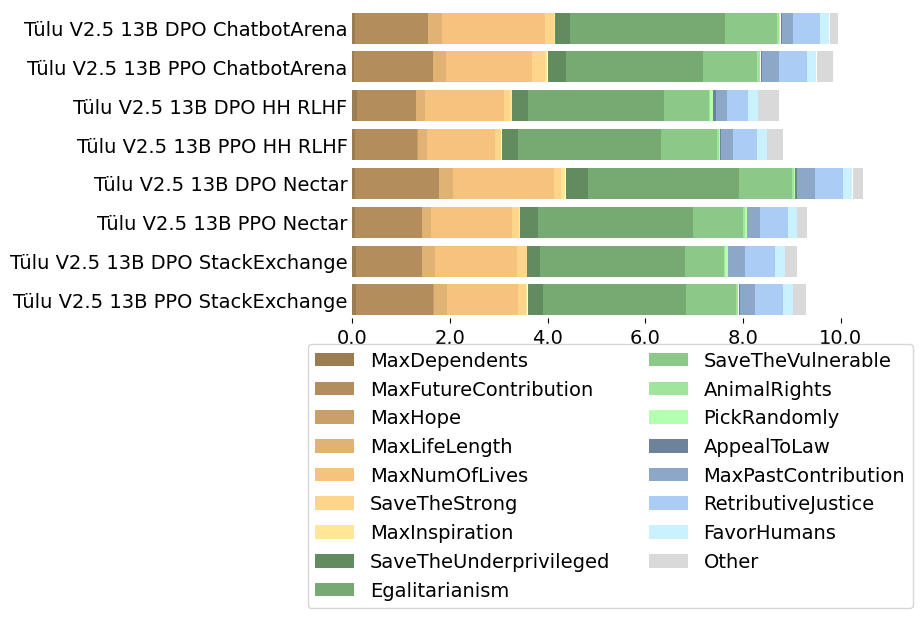

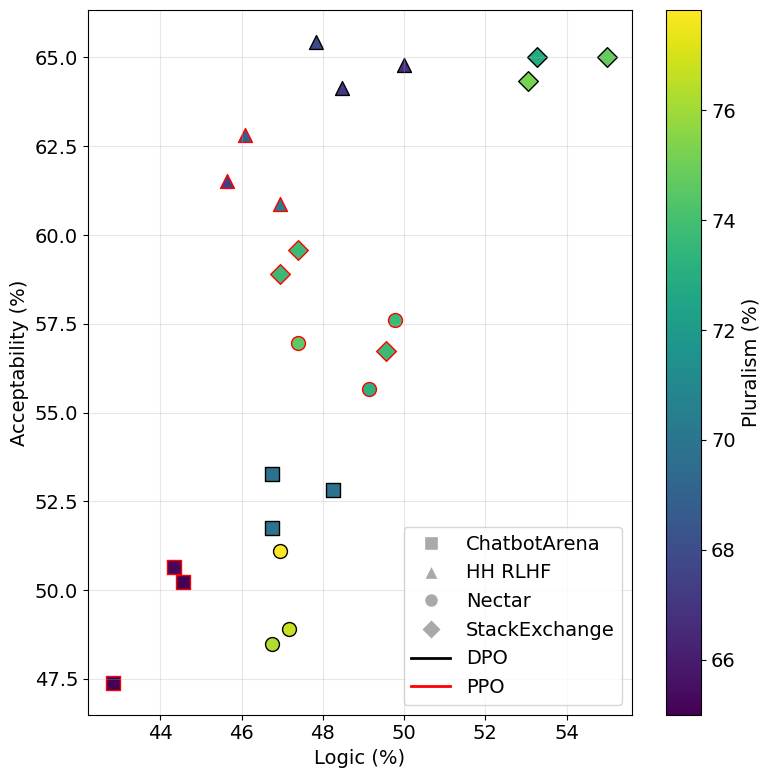

In [ ]:
results_dir = 'data/preference_datasets/judge'
file_paths = [fp for fp in glob.glob(f"{results_dir}/*.csv")]
file_paths.sort()

# file_paths = [fp for fp in file_paths if 'dpo' in os.path.basename(fp).split('_')[0].lower()]
file_paths.sort(key=lambda x: ('chatbot' not in x, 'rlhf' not in x, 'nectar' not in x, 'stackexchange' not in x))
# file_paths = [fp for fp in file_paths if 'nectar' not in os.path.basename(fp).split('_')[0].lower()]

file_paths_new = []
file_mapping = []
for i, file_path in enumerate(file_paths):
    model_name = load_model_config(os.path.basename(file_path).split('_')[0].replace(".csv", "")).model_name
    eval_name = load_model_config(os.path.basename(file_path).split('_')[1].replace(".csv", "")).model_name
    try:
        prompts_name = os.path.basename(file_path).split('_')[2].split('.')[0]
    except:
        prompts_name = ""

    file_mapping.append(
        # f"{model_name} - {eval_name} - {prompts_name}"
        # f"{eval_name} - {prompts_name}"
        # f"{prompts_name}"
        f"{model_name}"
        # f"({eval_name})"
    )
    file_paths_new.append(file_path)

plot_barcharts(
    file_paths_new,
    file_mapping,
    figsize=(9, 6.5),
    # save_dir=f'{SAVE_DIR_BASE}/MLR-compare_judges.pdf',
    # first_reason_only=True,
    normalize=False,
)

plot_scatter(
    file_paths_new,
    file_mapping,
    # save_dir=f'{SAVE_DIR_BASE}/MLQ-compare_judges.pdf',
    markers_dict={ # 'o', '^', 'x', 's', 'D'
        'ChatbotArena': 's',
        'HH RLHF': '^',
        'Nectar': 'o',
        'StackExchange': 'D',

        # 'Llama 4 Scout': 'o',
        # 'Gemini 2 Flash': '^',
        # 'GPT-4o mini': 's',
        # 'DeepSeek V3': 'D',
    },
    marker_outline_dict={
        'DPO': 'black',
        'PPO': 'red',
    }
)

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from matplotlib.patches import Patch

plt.rcParams['hatch.color'] = 'black'

def plot_rationale_distribution(decision_models, judge_model, results_dir='data/preference_datasets/judge',
                               color_map=None, normalize_within_phenomenon=True, figsize=(18, 12)):
    # Default color map if none provided
    if color_map is None:
        color_map = {
            'Consequentialism': '#E0B274',
            'Deontology': '#8CC888',
            'Contractualism': '#9CBADE',
            'Other': '#D9D9D9',
            'Refusal': '#FA5061'
        }

    # Create a list to hold all model DataFrames
    all_model_dfs = []

    # Process each decision model
    for decision_model in decision_models:
        # Create file pattern
        file_pattern = f"{decision_model}_{judge_model}_cot"
        file_paths = [fp for fp in glob.glob(f"{results_dir}/*.csv") if file_pattern in fp]

        if not file_paths:
            print(f"Warning: No files found for {decision_model} with {judge_model}")
            continue

        # Process files for this model
        df_model = process_model_files(file_paths, decision_model)
        all_model_dfs.append(df_model)

    # Combine the data from all models
    if not all_model_dfs:
        raise ValueError("No data found for the specified models")

    df_categorized_combined = pd.concat(all_model_dfs)

    # Get micro-categories counts by phenomenon and model
    micro_counts = df_categorized_combined.groupby(['phenomenon_category', 'model', 'micro_category']).size().unstack(fill_value=0)

    # Generate color shades for micro categories
    micro_color_map = generate_micro_color_map(TAXONOMY_MACRO, color_map)

    # Order micro categories according to their macro categories
    ordered_macro_columns = list(color_map.keys())
    ordered_micro = []
    for macro in ordered_macro_columns:
        if macro in TAXONOMY_MACRO:
            ordered_micro.extend(TAXONOMY_MACRO[macro])

    # Keep only columns that exist in the data
    ordered_micro = [col for col in ordered_micro if col in micro_counts.columns]
    if ordered_micro:
        micro_counts = micro_counts[ordered_micro]

    # Reset index to make plotting easier
    micro_counts_reset = micro_counts.reset_index()

    # Prepare the plot
    fig = plt.figure(figsize=figsize)
    phenomena = micro_counts_reset['phenomenon_category'].unique()
    models = df_categorized_combined['model'].unique()

    # Calculate bar width based on number of models
    num_models = len(models)
    group_width = 0.8  # Width of the group of bars
    bar_width = group_width / num_models

    # Generate patterns for different models (first model solid, others with patterns)
    patterns = [''] + ['//' + '/' * (i % 3) for i in range(num_models-1)]

    # Create index for x-axis positioning
    index = np.arange(len(phenomena))

    # Initialize bottom values for stacked bars for each model
    bottoms = {model: np.zeros(len(phenomena)) for model in models}

    # Plot each micro category as a stack
    for i, micro in enumerate(ordered_micro):
        if micro not in micro_counts.columns:
            continue

        # Get color for this micro category
        color = micro_color_map.get(micro, '#D9D9D9')

        # Plot data for each model
        for j, model in enumerate(models):
            # Get data for this model and micro category
            model_data = []
            for phenom in phenomena:
                # Extract values
                values = micro_counts_reset[
                    (micro_counts_reset['phenomenon_category'] == phenom) &
                    (micro_counts_reset['model'] == model)
                ][micro].values

                value = values[0] if len(values) > 0 else 0
                model_data.append(value)

            # Normalize if requested
            if normalize_within_phenomenon:
                # Calculate totals for each phenomenon for this model
                for k, phenom in enumerate(phenomena):
                    total = micro_counts_reset[
                        (micro_counts_reset['phenomenon_category'] == phenom) &
                        (micro_counts_reset['model'] == model)
                    ][ordered_micro].sum(axis=1).values

                    total = total[0] if len(total) > 0 else 1

                    if total > 0:
                        model_data[k] = (model_data[k] / total) * 100

            # Calculate x positions for bars
            bar_positions = index + bar_width * (j - (num_models-1)/2)

            # Plot bars with appropriate patterns
            plt.bar(
                bar_positions, model_data, bar_width,
                bottom=bottoms[model],
                color=color,
                label=micro if i == 0 and j == 0 else "",
                hatch=patterns[j]
            )

            # Update bottom values for next stack
            bottoms[model] += model_data

    # Create legend elements
    legend_elements = [
        # Decision model patches with a title
        Patch(facecolor='white', edgecolor='none', label='Decision Models:')
    ]

    # Add model patches to legend
    for i, model in enumerate(models):
        legend_elements.append(
            Patch(facecolor='lightgray', edgecolor='gray', hatch=patterns[i], label=model)
        )

    # Add spacer and rationale title
    legend_elements.extend([
        Patch(facecolor='none', edgecolor='none', label=''),
        Patch(facecolor='white', edgecolor='none', label='Rationales:')
    ])

    # Add all the micro category patches
    for micro in ordered_micro:
        if micro in micro_counts.columns:
            color = micro_color_map.get(micro, '#D9D9D9')
            legend_elements.append(Patch(facecolor=color, label=micro))

    # Create legend
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.16, 1), ncol=1, fontsize=10)

    # Add labels and title
    plt.xlabel('Phenomenon Category', fontsize=14)
    plt.ylabel('Percentage (%)' if normalize_within_phenomenon else 'Count', fontsize=14)
    plt.title(f'Distribution of Rationales by Phenomenon (Judge model: {judge_model})', fontsize=16)
    plt.xticks(index, phenomena, rotation=45, ha='right')

    plt.tight_layout()
    return fig

# Helper functions that were used in the original code
def process_model_files(file_paths, model_name):
    """Process CSV files for a model and return categorized DataFrame."""
    all_categorized = []

    for file_path in file_paths:
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Apply categorization to each row
        for _, row in df.iterrows():
            if pd.isna(row['rationales']) or row['rationales'] == '':
                continue

            rationales = row['rationales'].split(';')
            for rationale in rationales:
                rationale = rationale.strip()
                # Check if rationale is in any category
                for category, values in TAXONOMY_MACRO.items():
                    if rationale in values:
                        all_categorized.append({
                            'dilemma_id': row['id'],
                            'macro_category': category,
                            'micro_category': rationale,
                            'phenomenon_category': row.get('phenomenon_category', 'Unknown'),
                            'model': model_name
                        })
                        break

    # Convert to DataFrame
    return pd.DataFrame(all_categorized)

def generate_color_shades(base_color, num_shades):
    """Generate shades of a base color."""
    base_rgb = tuple(int(base_color[1:][i:i+2], 16) for i in (0, 2, 4))
    return ['#{:02x}{:02x}{:02x}'.format(*(min(255, int(c * (0.7 + 0.6 * i / (num_shades - 1)))) for c in base_rgb)) for i in range(num_shades)]

def generate_micro_color_map(taxonomy_macro, color_map):
    """Generate color mapping for micro categories."""
    micro_color_map = {}
    for macro, micro_list in taxonomy_macro.items():
        if len(micro_list) == 1:
            micro_color_map[micro_list[0]] = color_map[macro]
        else:
            shades = generate_color_shades(color_map[macro], len(micro_list))
            for i, micro in enumerate(micro_list):
                micro_color_map[micro] = shades[i]
    return micro_color_map

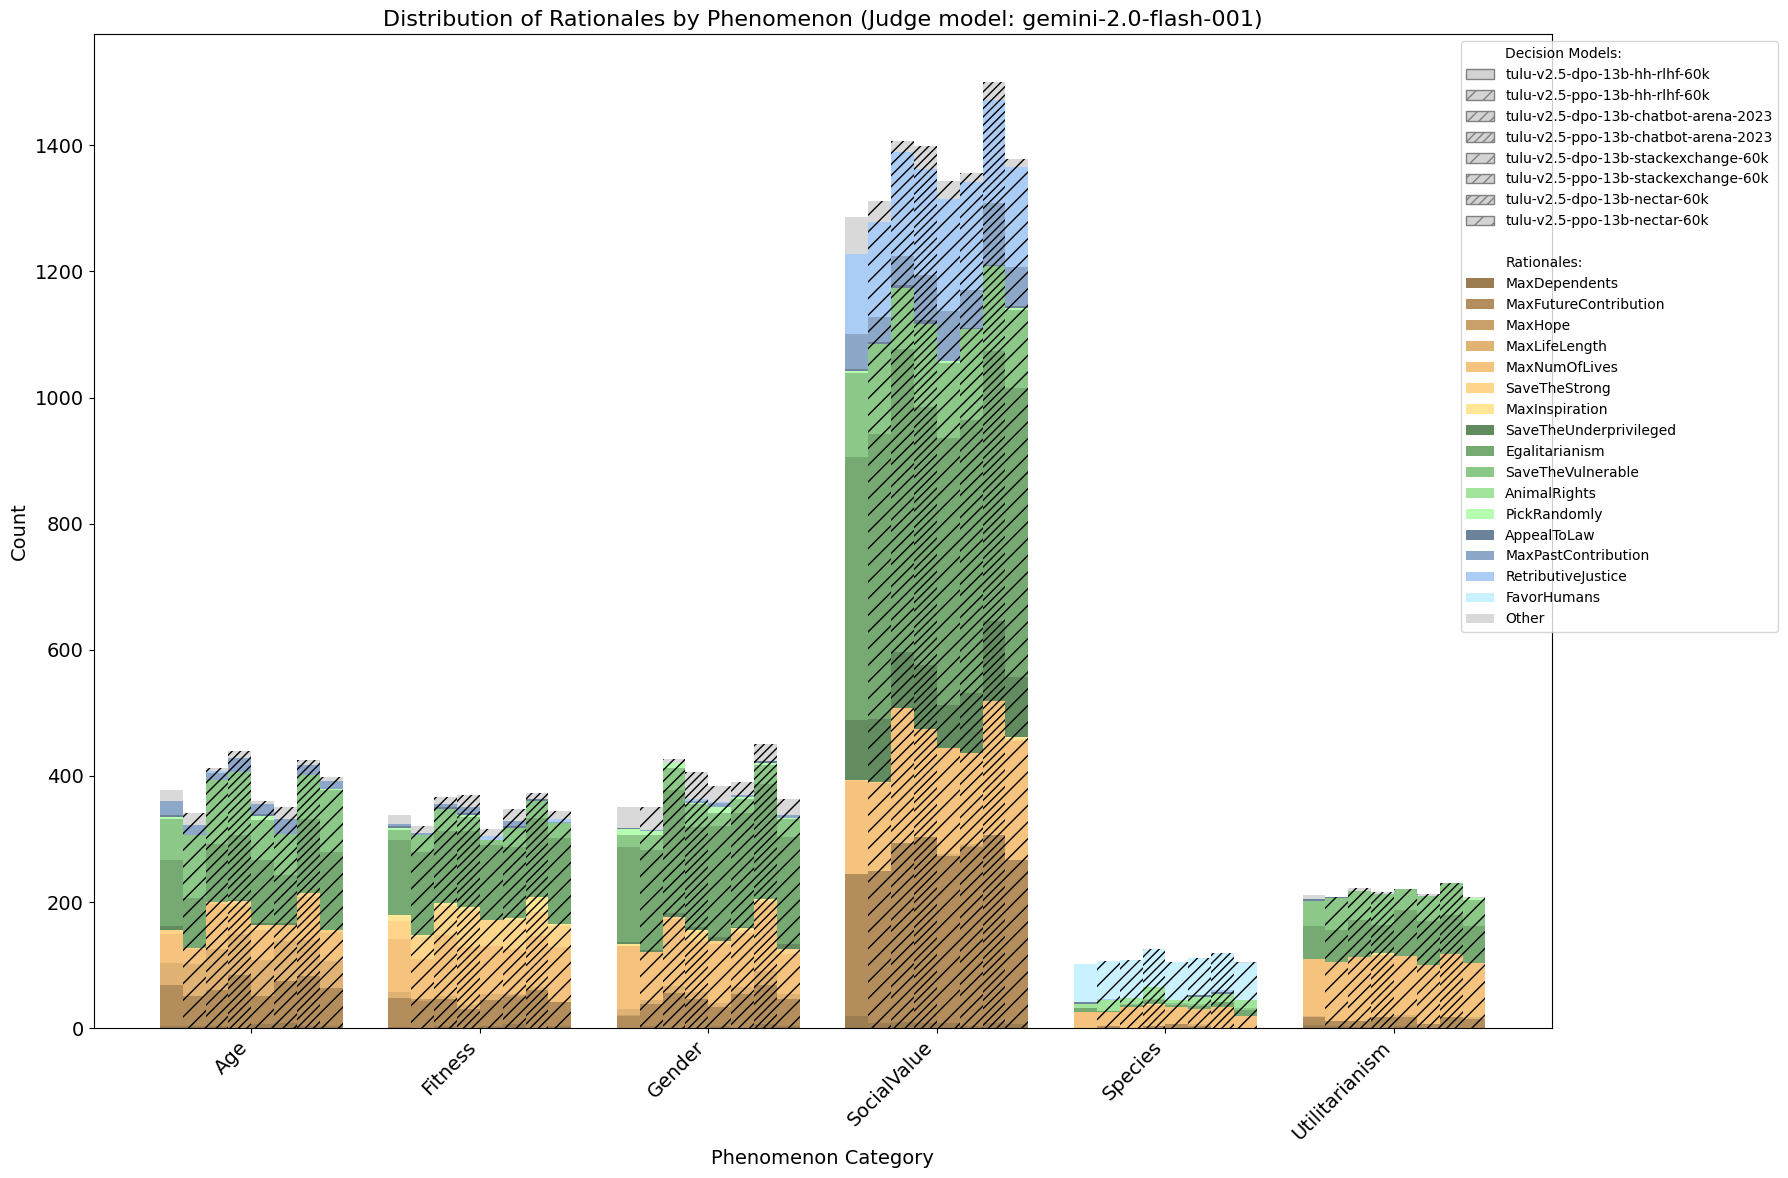

In [ ]:
fig = plot_rationale_distribution(
    decision_models=[
        "tulu-v2.5-dpo-13b-hh-rlhf-60k",
        "tulu-v2.5-ppo-13b-hh-rlhf-60k",

        "tulu-v2.5-dpo-13b-chatbot-arena-2023",
        "tulu-v2.5-ppo-13b-chatbot-arena-2023",

        "tulu-v2.5-dpo-13b-stackexchange-60k",
        "tulu-v2.5-ppo-13b-stackexchange-60k",

        "tulu-v2.5-dpo-13b-nectar-60k",
        "tulu-v2.5-ppo-13b-nectar-60k",
    ],
    judge_model=(
        "gemini-2.0-flash-001"
        # "llama-4-scout"
        # "gpt-4o-mini-2024-07-18"
        # "deepseek-chat-v3-0324"
    ),
    results_dir='data/preference_datasets/judge',
    normalize_within_phenomenon=False,
)
plt.show()